In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
from os.path import join, basename, dirname
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from natsort import natsorted
import torch

from torchvision.io import read_image

In [3]:
from experiment_utils import set_env, REPO_PATH, seed_everything
set_env()

In [4]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

In [29]:
def get_expt_from_path(path, prefix="experiments"):
    elements = path.split("/")
    idx = elements.index(prefix)
    return elements[idx + 1].split(".")[0]

### Classification results

In [62]:
# models trained on CF data
paths = glob(join(REPO_PATH, "cgn_framework", "mnists/experiments/", "classifier_*_seed_*/test_accs.pth"))

# models trained on original data
paths += glob(join(REPO_PATH, "cgn_framework", "mnists/experiments/", "classifier_*_MNIST/test_accs.pth"))

In [63]:
len(paths)

18

In [73]:
# df = pd.DataFrame(None)
df = []

for i, path in enumerate(paths):
    expt = get_expt_from_path(path)
    
    elements = expt.split("_")
    start, end = 1, elements.index("MNIST")
    dataset = "_".join(elements[start:end + 1])
    clf = "original" if not "counterfactual" in expt else "counterfactual"
    
    test_accs = torch.load(path)
    df.append([expt, dataset, clf, test_accs[10]])

df = pd.DataFrame(df, columns=["expt", "dataset", "model", "accuracy"])

In [74]:
df

,expt,dataset,model,accuracy
0,classifier_colored_MNIST_counterfactual_seed_0,colored_MNIST,counterfactual,92.43
1,classifier_colored_MNIST_counterfactual_seed_10,colored_MNIST,counterfactual,93.08
2,classifier_colored_MNIST_counterfactual_seed_20,colored_MNIST,counterfactual,93.57
3,classifier_colored_MNIST_counterfactual_seed_30,colored_MNIST,counterfactual,92.64
4,classifier_colored_MNIST_counterfactual_seed_40,colored_MNIST,counterfactual,92.91
5,classifier_double_colored_MNIST_counterfactual...,double_colored_MNIST,counterfactual,86.33
6,classifier_double_colored_MNIST_counterfactual...,double_colored_MNIST,counterfactual,86.79
7,classifier_double_colored_MNIST_counterfactual...,double_colored_MNIST,counterfactual,86.44
8,classifier_double_colored_MNIST_counterfactual...,double_colored_MNIST,counterfactual,86.73
9,classifier_double_colored_MNIST_counterfactual...,double_colored_MNIST,counterfactual,86.88


In [72]:
def apply_filters(df: pd.DataFrame, filters: dict, reset_index=False):
    """
    Filters df based on given filters (key-values pairs).
    """
    X = df.copy()

    for col, values in filters.items():
        if isinstance(values, (list, tuple, np.ndarray)):
            indices = X[col].isin(list(values))
        else:
            indices = X[col] == values
        X = X[indices]

    if reset_index:
        X = X.reset_index(drop=True)

    return X

In [86]:
# mean_df = pd.DataFrame(None, columns=["dataset", "model", "mean_accuracy", "std_accuracy"])
mean_df = []

for d, m in df[["dataset", "model"]].values:
    subdf = apply_filters(df, {"dataset": d, "model": m})
    # mean_df["mean_accuracy"] = subdf["accuracy"].mean()
    # mean_df["std_accuracy"] = subdf["accuracy"].std()
    mean_df.append([d, m, subdf["accuracy"].mean(), subdf["accuracy"].std()])

mean_df = pd.DataFrame(mean_df, columns=["dataset", "model", "mean_accuracy", "std_accuracy"])
mean_df.drop_duplicates(inplace=True)
mean_df.fillna(0, inplace=True)

In [89]:
mean_df["accuracy"] = mean_df["mean_accuracy"].astype(str) + " \pm " + mean_df["std_accuracy"].astype(str)

In [90]:
mean_df

,dataset,model,mean_accuracy,std_accuracy,accuracy
0,colored_MNIST,counterfactual,92.926,0.437756,92.926 \pm 0.437755639598162
5,double_colored_MNIST,counterfactual,86.634,0.236707,86.634 \pm 0.23670656940609106
10,wildlife_MNIST,counterfactual,81.394,0.440659,81.394 \pm 0.4406585980098435
15,colored_MNIST,original,37.350,0.000000,37.35 \pm 0.0
16,double_colored_MNIST,original,10.050,0.000000,10.05 \pm 0.0
17,wildlife_MNIST,original,10.800,0.000000,10.8 \pm 0.0


### Interpretability results

In [100]:
# get gradcam results

# models trained on CF data
paths = glob(join(REPO_PATH, "experiments", "results", "*_seed_*_gradcam_iou.pth"))

# models trained on original data
paths += glob(join(REPO_PATH, "experiments", "results", "*_MNIST_seed_0_gradcam_iou.pth"))

paths = np.unique(paths)

In [101]:
len(paths)

18

In [112]:
# df = pd.DataFrame(None)
df = []

for i, path in enumerate(paths):
    expt = get_expt_from_path(path, prefix="results")
    
    elements = expt.split("_")
    start, end = 0, elements.index("MNIST")
    dataset = "_".join(elements[start:end + 1])
    clf = "original" if not "counterfactual" in expt else "counterfactual"
    
    output = torch.load(path)
    df.append([expt, dataset, clf, output["overall_mean"], output["overall_std"]])

df = pd.DataFrame(df, columns=["expt", "dataset", "model", "mean iou", "std iou"])

In [113]:
df

,expt,dataset,model,mean iou,std iou
0,colored_MNIST_classifier_colored_MNIST_counter...,colored_MNIST,counterfactual,0.458936,0.068492
1,colored_MNIST_classifier_colored_MNIST_counter...,colored_MNIST,counterfactual,0.455063,0.059170
2,colored_MNIST_classifier_colored_MNIST_counter...,colored_MNIST,counterfactual,0.459971,0.070201
3,colored_MNIST_classifier_colored_MNIST_counter...,colored_MNIST,counterfactual,0.451551,0.060477
4,colored_MNIST_classifier_colored_MNIST_counter...,colored_MNIST,counterfactual,0.453279,0.058705
5,colored_MNIST_classifier_colored_MNIST_seed_0_...,colored_MNIST,original,0.439093,0.065101
6,double_colored_MNIST_classifier_double_colored...,double_colored_MNIST,counterfactual,0.429190,0.042256
7,double_colored_MNIST_classifier_double_colored...,double_colored_MNIST,counterfactual,0.427145,0.039312
8,double_colored_MNIST_classifier_double_colored...,double_colored_MNIST,counterfactual,0.437598,0.044681
9,double_colored_MNIST_classifier_double_colored...,double_colored_MNIST,counterfactual,0.428993,0.042867


In [114]:
# mean_df = pd.DataFrame(None, columns=["dataset", "model", "mean_accuracy", "std_accuracy"])
mean_df = []

for d, m in df[["dataset", "model"]].values:
    subdf = apply_filters(df, {"dataset": d, "model": m})
    # mean_df["mean_accuracy"] = subdf["accuracy"].mean()
    # mean_df["std_accuracy"] = subdf["accuracy"].std()
    mean_df.append([d, m, subdf["mean iou"].mean(), subdf["mean iou"].std()])

mean_df = pd.DataFrame(mean_df, columns=["dataset", "model", "avg of mean iou", "std of mean iou"])
mean_df.drop_duplicates(inplace=True)
mean_df.fillna(0, inplace=True)

In [115]:
mean_df

,dataset,model,avg of mean iou,std of mean iou
0,colored_MNIST,counterfactual,0.455760,0.003611
5,colored_MNIST,original,0.439093,0.000000
6,double_colored_MNIST,counterfactual,0.432224,0.005243
11,double_colored_MNIST,original,0.365139,0.000000
12,wildlife_MNIST,counterfactual,0.442981,0.003521
17,wildlife_MNIST,original,0.395882,0.000000


In [137]:
# massaing
df["model"] = df["model"].apply(lambda x: x.capitalize())
df["dataset"] = df["dataset"].apply(lambda x: x.replace("_", " "))

mean_df["model"] = mean_df["model"].apply(lambda x: x.capitalize())
mean_df["dataset"] = mean_df["dataset"].apply(lambda x: x.replace("_", " "))

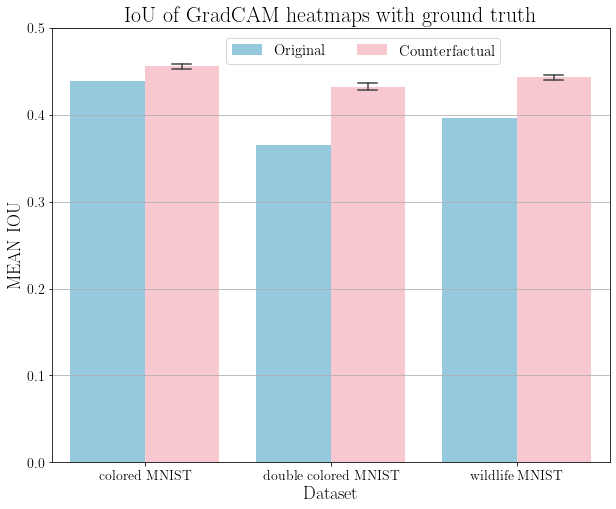

In [139]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.grid()
ax.set_title("IoU of GradCAM heatmaps with ground truth", fontsize=22)

sns.barplot(
    data=df,
    x="dataset",
    # y="avg of mean iou",
    y="mean iou",
    hue="model",
    palette=["skyblue", "pink"],
    hue_order=["Original", "Counterfactual"],
    errwidth=1.5,
    capsize=0.1,
)

ax.legend(bbox_to_anchor=(0.3, 0.9), fontsize=15, ncol=2)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xlabel(ax.get_xlabel().capitalize(), fontsize=18)
ax.set_ylabel(ax.get_ylabel().upper(), fontsize=18)
ax.set_ylim(0, 0.5)

plt.savefig(join(REPO_PATH, "experiments", "results", "quant_gradcam_iou_v2.pdf"), bbox_inches="tight")
plt.show()